In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time

## **Class implementation**

In [2]:
def fitness_magic_square222(individual: list[list], magic_number: int):
    """Calculates the number of rows/columns/diagonals that don't sum the magic number. The least, the better"""

    L = len(individual)
    bad_sums = 0

    for i in range(L):
        if sum(individual[i]) != magic_number: # check row sum
            bad_sums += 1
        if sum([row[i] for row in individual]) != magic_number: # check column sum
            bad_sums += 1

    if sum([individual[i][i] for i in range(L)]) != magic_number: # check primary diagonal
        bad_sums += 1

    if sum([individual[i][L-i-1] for i in range(L)]) != magic_number: # check secondary diagonal
        bad_sums += 1

    return bad_sums

def fitness_magic_square(individual: list[list], magic_number: int):
    """Calculates the sums of rows/columns/diagonals and absolute value with magic number. The closer to magic number, the better"""

    square = np.array(individual)
    
    row_sums = square.sum(axis=1)
    col_sums = square.sum(axis=0)
    diag_sum1 = np.sum(np.diag(square))
    diag_sum2 = np.sum(np.diag(np.fliplr(square)))

    fitness = (
        np.sum(abs(row_sums - magic_number)) +
        np.sum(abs(col_sums - magic_number)) +
        abs(diag_sum1 - magic_number) +
        abs(diag_sum2 - magic_number)
    )

    return int(fitness)

In [ ]:
class AG_Magic_Square():
    def __init__(self, population_size: int, N: int):
        """Create the population"""

        self.magic_number = int(N*(N**2 + 1) / 2)
        self.population = []
        self.fitnesses = []
    
        all_numbers = list(range(1, N**2 + 1)) # numbers between 1 and 64 (for 8x8 square)
        for _ in range(population_size):
            random.shuffle(all_numbers)
            individual = [all_numbers[i * N:(i + 1) * N] for i in range(N)] # slice list by 8-element lists
            self.population.append(individual)

    def sort_pop(self, fitness_function, reverse_sort: bool) -> tuple[list[list[list]], list]:
        """Sort population by fitness function. Return tuple with population list and fitness list"""

        fitness_list = [fitness_function(ind, self.magic_number) for ind in self.population]
        lista = sorted(zip(self.population, fitness_list), key=lambda x: x[1], reverse=reverse_sort)
        self.population = [x[0] for x in lista]
        self.fitnesses = [x[1] for x in lista]
    
    def select(self, T: int) -> list[list]:
        """Return a copy of an indivudual by tournament selection. Population already ordered by fitness"""

        choices=random.choices(copy.copy(self.population), k=T)
        indices=[self.population.index(c) for c in choices]
        return self.population[np.argmin(indices)]
    
    def crossover22(self, parent1: list[list[int]], parent2: list[list[int]], pcross: float) -> tuple[list[list[int]], list[list[int]]]:
        """Performs crossover, ensuring no duplicates and all numbers present."""

        child1 = parent1[:]
        child2 = parent2[:]

        if random.random() < pcross:
            size = len(parent1)  
            n = size * size
            crossover_rows = sorted(random.sample(range(size), size // 2))
            
            for row in crossover_rows:
                child1[row], child2[row] = parent2[row][:], parent1[row][:]

            # Repair duplicates and missing numbers in both children
            def repair_child(child: list[list[int]]) -> None:
                all_numbers = set(range(1, n + 1))
                used_numbers = {num for row in child for num in row}
                missing_numbers = iter(all_numbers - used_numbers)  # Missing numbers iterator

                # Keep track of numbers that appear more than once
                num_count = {}
                for row in child:
                    for num in row:
                        num_count[num] = num_count.get(num, 0) + 1

                # Replace duplicates with missing numbers
                for i in range(size):
                    for j in range(size):
                        if num_count[child[i][j]] > 1:  # If the number is duplicated
                            num_count[child[i][j]] -= 1  # Decrease count of duplicates
                            child[i][j] = next(missing_numbers)  # Replace with a missing number

            repair_child(child1)
            repair_child(child2)

        return child1, child2
    
    def crossover(self, parent1: list[list[int]], parent2: list[list[int]], pcross: float) -> tuple[list[list[int]], list[list[int]]]:
        """Performs crossover, ensuring no duplicates and all numbers present."""

        child1 = parent1[:]
        child2 = parent2[:]

        if random.random() < pcross:
            size = len(parent1)  
            n = size * size
            crossover_rows = sorted(random.sample(range(size), size // 2))
            
            

        return child1, child2


    def mutate(self, individual: list[list], pmut: float) -> list:
        """Mutate an individual, swap elements. Return mutated individual"""

        def swap_cells():
            """Swap random cells of the square"""
            row1, col1, row2, col2 = random.choices(range(n), k=4)
            individual[row1][col1], individual[row2][col2] = individual[row2][col2], individual[row1][col1]

        def shuffle_row():
            """Shuffle a square row"""
            row_index = random.choice(range(n))
            random.shuffle(individual[row_index])
        
        def shuffle_column():
            """Shuffle a square column"""
            column_index = random.choice(range(n))
            column = [row[column_index] for row in individual]
            random.shuffle(column)
            for i in range(n):
                individual[i][column_index] = column[i]

        def swap_blocks():
            """Split square in subgrids and swap two of them"""
            block_size = max(1, n // 2)

            # Helper to get indices of a block
            def get_block_indices(start_row, start_col, block_size):
                return [(r, c) for r in range(start_row, start_row + block_size) 
                               for c in range(start_col, start_col + block_size)]

            # Select two random blocks
            start_row1, start_col1 = random.randint(0, n - block_size), random.randint(0, n - block_size)
            start_row2, start_col2 = random.randint(0, n - block_size), random.randint(0, n - block_size)
            
            # Get the indices of these blocks
            block1 = get_block_indices(start_row1, start_col1, block_size)
            block2 = get_block_indices(start_row2, start_col2, block_size)

            # Swap values between blocks
            for (r1, c1), (r2, c2) in zip(block1, block2):
                individual[r1][c1], individual[r2][c2] = individual[r2][c2], individual[r1][c1]
        
        if random.random() < pmut:
            n = len(individual)
            mutations = [swap_cells, shuffle_row, shuffle_column, swap_blocks]
            chosen_mutation = random.choice(mutations)
            chosen_mutation()

        return individual

    def evolve(self, fitness_function, pmut=0.1, pcross=0.75, ngen=100, T=3, trace=50, reverse_sort=False, elitism=False) -> None:
        """Evolution procedure. Initial population already created"""

        for i in range(ngen):
            new_pop = []
            self.sort_pop(fitness_function, reverse_sort)
            if elitism:
                new_pop.append(self.population[0])
                new_pop.append(self.population[1])
            while len(new_pop) != 100:   
                individual1 = self.select(T)
                individual2 = self.select(T)
                child1, child2 = self.crossover(individual1, individual2, pcross)
                mutated1 = self.mutate(child1, pmut)
                mutated2 = self.mutate(child2, pmut)
                new_pop.append(mutated1)
                new_pop.append(mutated2)
                
            self.population = [*new_pop] # make a copy

            if i % trace == 0 or i == ngen-1: # en la última gen se ordena
                self.sort_pop(fitness_function, reverse_sort)
                print(f"Nº gen: {i}, Best fitness: {self.fitnesses[0]}")

## **Visual test**

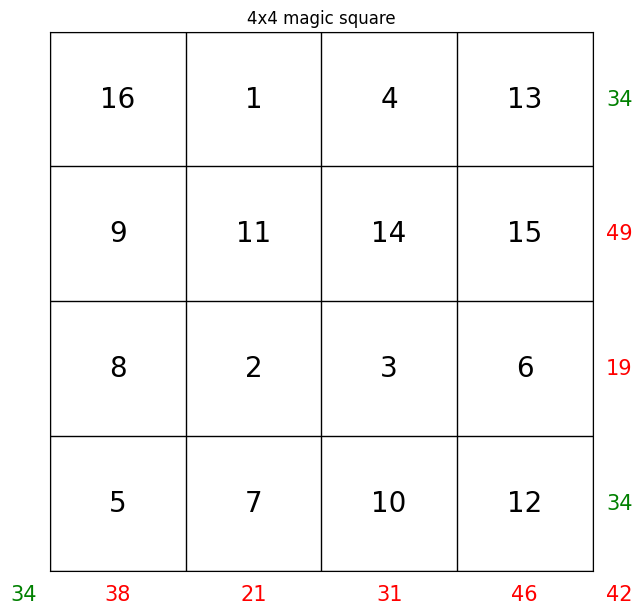

In [ ]:
def draw_solution(square):
    N = len(square)
    magic_sum = int(N*(N**2+1) / 2)
    
    # Convert the square into a numpy array for easier manipulation
    square = np.array(square)
    row_sums = square.sum(axis=1)
    col_sums = square.sum(axis=0)
    diag_sum1 = np.sum(np.diag(square))
    diag_sum2 = np.sum(np.diag(np.fliplr(square)))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Remove extra space and ticks
    ax.set_xlim(-0.5, N - 0.5)
    ax.set_ylim(-0.5, N - 0.5)
    ax.invert_yaxis()  # Fix the upside-down issue
    ax.set_xticks([])
    ax.set_yticks([])
    
    # grid lines
    for i in range(N + 1):
        ax.plot([-0.5, N - 0.5], [i - 0.5, i - 0.5], color="black", linewidth=1)
        ax.plot([i - 0.5, i - 0.5], [-0.5, N - 0.5], color="black", linewidth=1)
    
    # numbers inside the grid
    for i in range(N):
        for j in range(N):
            ax.text(j, i, str(square[i, j]), va='center', ha='center', color='black', fontsize=20)
    
    # row sums to the right
    for i in range(N):
        row_color = 'green' if row_sums[i] == magic_sum else 'red'
        ax.text(N - 0.4, i, str(row_sums[i]), va='center', ha='left', color=row_color, fontsize=15)

    # column sums below
    for j in range(N):
        col_color = 'green' if col_sums[j] == magic_sum else 'red'
        ax.text(j, N - 0.4, str(col_sums[j]), va='top', ha='center', color=col_color, fontsize=15)
    
    # diagonal sums at the bottom corners
    diag_color1 = 'green' if diag_sum1 == magic_sum else 'red'
    diag_color2 = 'green' if diag_sum2 == magic_sum else 'red'
    ax.text(N - 0.4, N - 0.4, str(diag_sum1), va='top', ha='left', color=diag_color1, fontsize=15)
    ax.text(-0.6, N - 0.4, str(diag_sum2), va='top', ha='right', color=diag_color2, fontsize=15)
    
    plt.title(f"{N}x{N} magic square")
    plt.show()
# ----------------------------------------------
magic_square = [
    [35, 1, 6, 26, 19, 24],
    [3, 32, 7, 21, 23, 25],
    [31, 9, 2, 22, 27, 20],
    [8, 28, 33, 17, 10, 15],
    [30, 5, 34, 12, 14, 16],
    [4, 36, 29, 13, 18, 11]
]
draw_solution(magic_square)

## **---------------------------Tests---------------------------**

In [9]:
N = 8 # tablero NxN
genetic_algorithm = AG_Magic_Square(100, N)

start = time.time()
genetic_algorithm.evolve(fitness_function=fitness_magic_square, pmut=0.1, ngen=10000, T=6, trace=500)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo evolución: {int(minutos)} minutos y {segundos:.2f} segundos*******")

print(genetic_algorithm.population[0])
draw_solution(genetic_algorithm.population[0])

Nº gen: 0, Best fitness: 481
Nº gen: 500, Best fitness: 404
Nº gen: 1000, Best fitness: 437
Nº gen: 1500, Best fitness: 399
Nº gen: 2000, Best fitness: 459
Nº gen: 2500, Best fitness: 398


KeyboardInterrupt: 